#                                      Курсовой проект

### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)
Решение должно содержать

### Описание датасета

Home Ownership - домовладение

Annual Income - годовой доход

Years in current job - количество лет на текущем месте работы

Tax Liens - налоговые обременения

Number of Open Accounts - количество открытых счетов

Years of Credit History - количество лет кредитной истории

Maximum Open Credit - наибольший открытый кредит

Number of Credit Problems - количество проблем с кредитом

Months since last delinquent - количество месяцев с последней просрочки платежа

Bankruptcies - банкротства

Purpose - цель кредита

Term - срок кредита

Current Loan Amount - текущая сумма кредита

Current Credit Balance - текущий кредитный баланс

Monthly Debt - ежемесячный долг

Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [56]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [57]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [58]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [59]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5943.00000,7500.00000,7500.00000,7500.00000,7500.00000,7500.00000,3419.00000,7486.00000,7500.00000,7500.00000,7500.00000,5943.00000,7500.00000
mean,1366391.72017,0.03013,11.13093,18.31747,945153.72747,0.17000,34.69260,0.11715,11873177.44507,289833.23520,18314.45413,1151.08750,0.28173
std,845339.19963,0.27160,4.90892,7.04195,16026216.67085,0.49860,21.68881,0.34719,31926122.97473,317871.38238,11926.76467,1604.45142,0.44987
min,164597.00000,0.00000,2.00000,4.00000,0.00000,0.00000,0.00000,0.00000,11242.00000,0.00000,0.00000,585.00000,0.00000
25%,844341.00000,0.00000,8.00000,13.50000,279229.50000,0.00000,16.00000,0.00000,180169.00000,114256.50000,10067.50000,711.00000,0.00000
50%,1168386.00000,0.00000,10.00000,17.00000,478159.00000,0.00000,32.00000,0.00000,309573.00000,209323.00000,16076.50000,731.00000,0.00000
75%,1640137.00000,0.00000,14.00000,21.80000,793501.50000,0.00000,50.00000,0.00000,519882.00000,360406.25000,23818.00000,743.00000,1.00000
max,10149344.00000,7.00000,43.00000,57.70000,1304726170.00000,7.00000,118.00000,4.00000,99999999.00000,6506797.00000,136679.00000,7510.00000,1.00000


Не знаю, что за валюта, но если прикинуть по ЗП,  минимальная в год 164597, это ~13к в месяц, что впринципе МРОТ в РФ, так что будем считать, что валюта Рубли.

- Maximum Open Credit обработать выбросы
- Current Loan Amount обработать выбросы
- Current Credit Balance - посмотреть выброс или нет.

### Выбросы

#### Maximum Open Credit

<AxesSubplot:xlabel='Maximum Open Credit'>

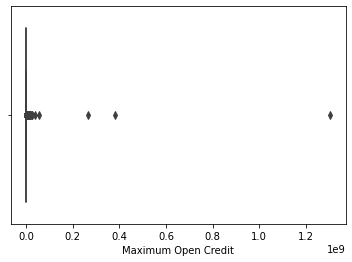

In [60]:
sns.boxplot(df_train['Maximum Open Credit'])

Значения совсем фантастические. Заменим все что выше q=0.975 медианой.

In [61]:
max_open_credit = np.quantile(df_train['Maximum Open Credit'], q=0.975)
max_open_credit_median = df_train['Maximum Open Credit'].median()

### Current Loan Amount

In [69]:
df_train['Current Loan Amount'].value_counts()

99999999.00000    870
218064.00000        6
89298.00000         6
216106.00000        5
265826.00000        5
                 ... 
104324.00000        1
201080.00000        1
427812.00000        1
665544.00000        1
191136.00000        1
Name: Current Loan Amount, Length: 5386, dtype: int64

<AxesSubplot:>

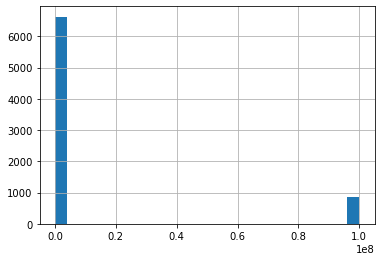

In [68]:
df_train['Current Loan Amount'].hist(bins=25)

Я так подозреваю значение 99999999 это правое скопление, явно не являющееся нормальным.

In [72]:
df_train.loc[df_train['Current Loan Amount'] != 99999999]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.00000,10+ years,0.00000,15.00000,15.30000,1181730.00000,0.00000,NaN,0.00000,debt consolidation,Long Term,264968.00000,394972.00000,18373.00000,737.00000,1
3,Own Home,805068.00000,6 years,0.00000,8.00000,22.50000,147400.00000,1.00000,NaN,1.00000,debt consolidation,Short Term,121396.00000,95855.00000,11338.00000,694.00000,0
4,Rent,776264.00000,8 years,0.00000,13.00000,13.60000,385836.00000,1.00000,NaN,0.00000,debt consolidation,Short Term,125840.00000,93309.00000,7180.00000,719.00000,0
5,Rent,NaN,7 years,0.00000,12.00000,14.60000,366784.00000,0.00000,NaN,0.00000,other,Long Term,337304.00000,165680.00000,18692.00000,NaN,1
7,Rent,1040060.00000,10+ years,0.00000,13.00000,12.00000,330374.00000,0.00000,18.00000,0.00000,other,Short Term,250888.00000,89015.00000,19761.00000,705.00000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,Own Home,NaN,< 1 year,0.00000,7.00000,8.20000,301554.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,290400.00000,210938.00000,5070.00000,NaN,0
7495,Rent,402192.00000,< 1 year,0.00000,3.00000,8.50000,107866.00000,0.00000,NaN,0.00000,other,Short Term,129360.00000,73492.00000,1900.00000,697.00000,0
7496,Home Mortgage,1533984.00000,1 year,0.00000,10.00000,26.50000,686312.00000,0.00000,43.00000,0.00000,debt consolidation,Long Term,444048.00000,456399.00000,12783.00000,7410.00000,1
7498,Home Mortgage,NaN,NaN,0.00000,21.00000,26.50000,1141250.00000,0.00000,NaN,0.00000,debt consolidation,Short Term,615274.00000,476064.00000,37118.00000,NaN,0


In [62]:
def prep_data(df):
    
    #Выбросы
    
    df.loc[df_train['Maximum Open Credit'] > max_open_credit, 'Maximum Open Credit'] = max_open_credit_median
    
    return df

In [63]:
prep_data = prep_data(df_train)